In [25]:
import dash
from dash.dependencies import Output, Input
from dash import dcc, html, dcc
import json
import plotly.graph_objs as go
from collections import deque
from flask import Flask, request
import socket
import json
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
import sys
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# **3. Socket Programming: RESTFul API**

show the real-time data from app to local host.

In [ ]:
server = Flask(__name__)
app = dash.Dash(__name__, server=server)

MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

time = deque(maxlen=MAX_DATA_POINTS)
accel_x = deque(maxlen=MAX_DATA_POINTS)
accel_y = deque(maxlen=MAX_DATA_POINTS)
accel_z = deque(maxlen=MAX_DATA_POINTS)

app.layout = html.Div(
	[
		dcc.Markdown(
			children="""
			# Live Sensor Readings
			Streamed from Sensor Logger: tszheichoi.com/sensorlogger
		"""
		),
		dcc.Graph(id="live_graph"),
		dcc.Interval(id="counter", interval=UPDATE_FREQ_MS),
	]
)


@app.callback(Output("live_graph", "figure"), Input("counter", "n_intervals"))
def update_graph(_counter):
	data = [
		go.Scatter(x=list(time), y=list(d), name=name)
		for d, name in zip([accel_x, accel_y, accel_z], ["X", "Y", "Z"])
	]

	graph = {
		"data": data,
		"layout": go.Layout(
			{
				"xaxis": {"type": "date"},
				"yaxis": {"title": "Acceleration ms<sup>-2</sup>"},
			}
		),
	}
	if (
		len(time) > 0
	):  #  cannot adjust plot ranges until there is at least one data point
		graph["layout"]["xaxis"]["range"] = [min(time), max(time)]
		graph["layout"]["yaxis"]["range"] = [
			min(accel_x + accel_y + accel_z),
			max(accel_x + accel_y + accel_z),
		]

	return graph


@server.route("/data", methods=["POST"])
def data():  # listens to the data streamed from the sensor logger
	if str(request.method) == "POST":
		print(f'received data: {request.data}')
		data = json.loads(request.data)
		for d in data['payload']:
			if (
				d.get("name", None) == "accelerometer"
			):  #  modify to access different sensors
				ts = datetime.fromtimestamp(d["time"] / 1000000000)
				if len(time) == 0 or ts > time[-1]:
					time.append(ts)
					# modify the following based on which sensor is accessed, log the raw json for guidance
					accel_x.append(d["values"]["x"])
					accel_y.append(d["values"]["y"])
					accel_z.append(d["values"]["z"])
	return "success"


if __name__ == "__main__":
	app.run_server(port=8000, host="192.168.50.50")

Record the data pushed via http connection, then save it to a json file

In [ ]:
host = "192.168.50.50"  # The server's hostname or IP address
port = 8000  # The port used by the server

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((host, port))
    s.listen()
    conn, addr = s.accept()
    with conn:
        print(f"Connected by {addr}")
        while True:
            print(f"Connected by {addr}")
            data = conn.recv(1024).decode('utf-8')
            #data_json = json.loads(data.data)
            with open("sensor_loger.json", "w") as outfile:
                json.dump(data, outfile)
            if not data:
                break
    conn.close()

print('server closed')

parsed_data = json.loads(r"./sample.json")

#parse out json to csv
df = pd.read_json('sensor_loger.json')
df.to_csv('sensor_loger.csv')

# **4. Clustering: Hierarchical Clustering from Scratch**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
walking = pd.read_json('drive/My Drive/Rutgers/579ADV TOPICS/HW3/walking.json')
running = pd.read_json('drive/My Drive/Rutgers/579ADV TOPICS/HW3/running.json')
jumping = pd.read_json('drive/My Drive/Rutgers/579ADV TOPICS/HW3/jumping.json')

Pre_process the data, we only keep 'Accelerometer','Gravity','Gyroscope', and concat them for each sample

In [9]:
def pre_process(df):
    #df = df[df['sensor'].isin(['Accelerometer','Gravity','Gyroscope'])]
    cols = ['z', 'y', 'x']
    df_acc = df[df['sensor'] == 'Accelerometer'][cols]
    df_acc.columns = ['acc_z', 'acc_y', 'acc_x']
    df_gra = df[df['sensor'] == 'Gravity'][cols]
    df_gra.columns = ['gra_z', 'gra_y', 'gra_x']
    df_gyr = df[df['sensor'] == 'Gyroscope'][cols]
    df_gyr.columns = ['gyr_z', 'gyr_y', 'gyr_x']
    df_n = pd.concat([df_acc.reset_index(drop=True),df_gra.reset_index(drop=True), df_gyr.reset_index(drop=True)], axis = 1)
    return df_n

walking = pre_process(walking)
running = pre_process(running)
jumping = pre_process(jumping)

Data preview

In [13]:
walking.head()

,acc_z,acc_y,acc_x,gra_z,gra_y,gra_x,gyr_z,gyr_y,gyr_x
0,-0.013715,0.057398,-0.094170,-8.588352,-4.731329,0.158514,-0.086077,-0.134885,0.361282
1,0.023107,0.060199,-0.145479,-8.571605,-4.761812,0.152063,-0.112431,-0.129791,0.352609
2,-0.073480,0.120592,-0.200742,-8.555373,-4.791081,0.146723,-0.135364,-0.134333,0.337411
3,-0.017789,0.106153,-0.294088,-8.540284,-4.818091,0.141159,-0.152729,-0.161754,0.296673
4,0.088464,-0.009497,-0.333702,-8.528624,-4.839061,0.128249,-0.118680,-0.314458,0.192562


Now we only keep 3000 samples for each activity.

In [14]:
running3000 = running.iloc[100:3100,].reset_index(drop=True).to_numpy()
walking3000 = walking.iloc[100:3100,].reset_index(drop=True).to_numpy()
jumping3000 = jumping.iloc[100:3100,].reset_index(drop=True).to_numpy()
combined_data = np.concatenate([running3000,walking3000,jumping3000])

In [16]:
def find_clusters(dist_ma,linkage = None):
    clusters = {}
    row_index = -1
    col_index = -1
    array = []

    for n in range(dist_ma.shape[0]):
        array.append(n)

    clusters[0] = array.copy()

    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
    for k in range(1, dist_ma.shape[0]):
        min_val = sys.maxsize

        for i in range(0, dist_ma.shape[0]):
            for j in range(0, dist_ma.shape[1]):
                if(dist_ma[i][j]<=min_val):
                    min_val = dist_ma[i][j]
                    row_index = i
                    col_index = j

        #once we find the minimum value, we need to update the distance matrix
        #updating the matrix by calculating the new distances from the cluster to all points

        if(linkage=='farthest'):
             for i in range(0,dist_ma.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = min(dist_ma[col_index][i],dist_ma[row_index][i])
                    dist_ma[col_index][i] = temp
                    dist_ma[i][col_index] = temp
        #for Average Linkage
        else:
             for i in range(0,dist_ma.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = (dist_ma[col_index][i]+dist_ma[row_index][i])/2
                    dist_ma[col_index][i] = temp
                    dist_ma[i][col_index] = temp

        #set the rows and columns for the cluster with higher index i.e. the row index to infinity
        #Set input[row_index][for_all_i] = infinity
        #set input[for_all_i][row_index] = infinity
        for i in range (0,dist_ma.shape[0]):
            dist_ma[row_index][i] = sys.maxsize
            dist_ma[i][row_index] = sys.maxsize

        #Manipulating the dictionary to keep track of cluster formation in each step
        #if k=0,then all datapoints are clusters

        minimum = min(row_index,col_index)
        maximum = max(row_index,col_index)
        for n in range(len(array)):
            if(array[n]==maximum):
                array[n] = minimum
        clusters[k] = array.copy()

    return clusters

In [ ]:
combined_data

In [28]:
initial_distances = pairwise_distances(combined_data,metric='euclidean')
#making all the diagonal elements infinity
np.fill_diagonal(initial_distances,sys.maxsize)
clusters = find_clusters(initial_distances)

In [29]:
print(clusters)

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,

# **5. Clustering: Partitional Clustering w/K-means**

In [30]:
class KMeans():

    def __init__(self,k = 3,max_iters = 100):  # No need to implement
        self.k = k
        self.max_iters = max_iters

    def pairwise_dist(self, x, y):  # [5 pts]

        xSumSquare = np.sum(np.square(x),axis=1);
        ySumSquare = np.sum(np.square(y),axis=1);
        mul = np.dot(x, y.T);
        dists = np.sqrt(abs(xSumSquare[:, np.newaxis] + ySumSquare-2*mul))
        return dists

    def _init_centers(self, points):  # [5 pts]

        row, col = points.shape
        retArr = np.empty([self.k, col])
        for number in range(self.k):
            randIndex = np.random.randint(row)
            retArr[number] = points[randIndex]

        return retArr

    def _update_assignment(self, centers, points):  # [10 pts]

        row, col = points.shape
        cluster_idx = np.empty([row])
        distances = self.pairwise_dist(points, centers)
        cluster_idx = np.argmin(distances, axis=1)

        return cluster_idx

    def _update_centers(self, old_centers, cluster_idx, points):  # [10 pts]

        K, D = old_centers.shape
        new_centers = np.empty(old_centers.shape)
        for i in range(K):
            new_centers[i] = np.mean(points[cluster_idx == i], axis = 0)
        return new_centers

    def _get_loss(self, centers, cluster_idx, points):
        dists = self.pairwise_dist(points, centers)
        loss = 0.0
        N, D = points.shape
        for i in range(N):
            loss = loss + np.square(dists[i][cluster_idx[i]])
        return loss


    def call(self, points):

        iteration = 0
        centers = self._init_centers(points)
        prev_centers = None
        while np.not_equal(centers, prev_centers).any() and iteration < self.max_iters:
            cluster_idx = self._update_assignment(centers, points)
            prev_centers = centers
            centers = self._update_centers(centers, cluster_idx, points)
            loss = self._get_loss(centers, cluster_idx, points)
            if np.isnan(centers).any():
                centers = prev_centers
            iteration += 1
            #print('Running iteration: {}, loss: {}'.format(iteration,loss))
        return cluster_idx, centers, loss

In [19]:
def plot_elbow(data, max_K=10):
        y_val = np.empty(max_K)
        for i in range(max_K):
            model = KMeans(k = i+1,max_iters = 100)
            idx, c, y_val[i] = model.call(data)
        plt.plot(np.arange(max_K) + 1, y_val)
        plt.show()
        return y_val

check k-means with k=3

In [20]:
model = KMeans(k = 3,max_iters = 100)
idx, c, loss = model.call(combined_data)

Running iteration: 1, loss: 1024832.7925529422
Running iteration: 2, loss: 941936.8023203951
Running iteration: 3, loss: 919387.6138183179
Running iteration: 4, loss: 908648.6176924442
Running iteration: 5, loss: 902247.4429727063
Running iteration: 6, loss: 899083.819463219
Running iteration: 7, loss: 897793.806057581
Running iteration: 8, loss: 897346.021977149
Running iteration: 9, loss: 897199.8028858366
Running iteration: 10, loss: 897163.7838792283
Running iteration: 11, loss: 897156.2664161347
Running iteration: 12, loss: 897155.6891949441
Running iteration: 13, loss: 897155.6891949441


In [21]:
print(idx)

[0 0 0 ... 1 1 1]


Perform PCA and plot

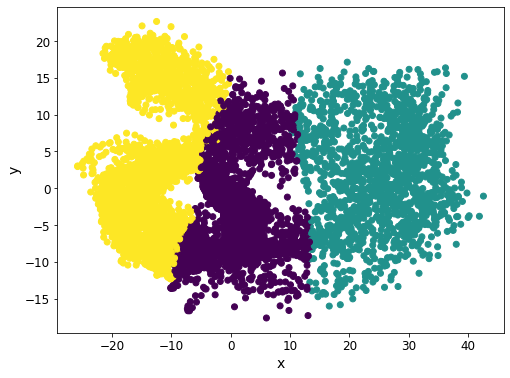

In [26]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(combined_data)

#customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=pca_data[:,0], y=pca_data[:,1], #s=150,
            c=idx)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Plot elbow

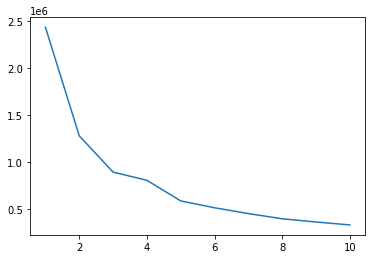

array([2436123.50823058, 1282640.73709167,  897155.68919494,
        810154.93699629,  590744.90866419,  517765.38096633,
        456239.95995914,  400970.20073093,  366799.52777153,
        335667.57249341])

In [33]:
plot_elbow(combined_data)

k=3 seems like the elbow and it matches the number of activities